In [1]:
%run imports.ipynb

## Metadata (variant calls)

In [71]:
meta = pd.read_csv('source_data/li2016_variant_calls.csv')
run2status = {r.run_rrbs:r.status for r in meta.to_records()} # SRR* -> R882/Other/WT/INS

## R882 vs WT DMR statistics

There are 465 R882 hypo-DMRs vs WT.
There are 62 R882 hypo-DMRs vs WT.


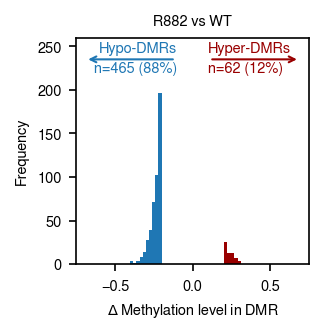

In [70]:
r882_dmrs = pd.read_csv('source_data/r882_vs_wt_dmrs.csv')

print(f'There are %d R882 hypo-DMRs vs WT.' % len(r882_dmrs[(r882_dmrs.q_value < 1e-2) & (r882_dmrs.mean_difference < 0)]))
print(f'There are %d R882 hypo-DMRs vs WT.' % len(r882_dmrs[(r882_dmrs.q_value < 1e-2) & (r882_dmrs.mean_difference > 0)]))

p_cutoff = 1e-2
y_max = 260
bin_size = 0.02

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)

d_sig = r882_dmrs[(r882_dmrs.q_value < p_cutoff)]
hypo_dmrs = r882_dmrs[(r882_dmrs.q_value < p_cutoff) & (r882_dmrs.mean_difference < 0)]
hyper_dmrs = r882_dmrs[(r882_dmrs.q_value < p_cutoff) & (r882_dmrs.mean_difference > 0)]

hypo_dmrs.mean_difference.plot.hist(bins=int((hypo_dmrs.mean_difference.max() - hypo_dmrs.mean_difference.min()) // bin_size),
                                    lw=0, fc='C0', histtype='stepfilled', ax=ax)
hyper_dmrs.mean_difference.plot.hist(bins=int((hyper_dmrs.mean_difference.max() - hyper_dmrs.mean_difference.min()) // bin_size),
                                     lw=0, fc='#990000', histtype='stepfilled', ax=ax)

ax.set_xlim([-0.75, 0.75])
ax.set_ylim([0, y_max])

y_label = y_max - 12
ax.text(0.1, y_label, f'Hyper-DMRs', ha='left', va='center', color='#990000')
ax.text(-0.1, y_label, f'Hypo-DMRs', ha='right', va='center', color='C0')

y_arrow = y_max - 25
ax.annotate('', (0.7, y_arrow), (0.1, y_arrow), arrowprops={'arrowstyle': '->', 'lw': 1, 'color': '#990000'})
ax.annotate('', (-0.7, y_arrow), (-0.1, y_arrow), arrowprops={'arrowstyle': '->', 'lw': 1, 'color': 'C0'})

y_n = y_max - 40
ax.text(0.1, y_n, f'n={len(hyper_dmrs)} ({len(hyper_dmrs) / len(d_sig):.0%})', ha='left', color='#990000')
ax.text(-0.1, y_n, f'n={len(hypo_dmrs)} ({len(hypo_dmrs) / len(d_sig):.0%})', ha='right', color='C0')
ax.set_xlabel('$\Delta$ Methylation level in DMR', fontsize=7)

ax.set_ylabel('Frequency', fontsize=7)
ax.set_title('R882 vs WT', fontsize=7)

save_figures('source_data_figures/dmr_analysis/r882_wt_dmr_statistics')

### Beta value pileup in R882-vs-WT hypo-DMRs

In [13]:
intersect_results = glob.glob('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-DMR-PILEUP/result/intersect/*.r882_vs_wt_hypo.bed')
closest_results = glob.glob('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-DMR-PILEUP/result/closest/*.r882_vs_wt_hypo.bed')

len(intersect_results), len(closest_results)

(108, 108)

In [14]:
intersect_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'rel_pos']
closest_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'distance']

intersect_data = []

for fp in tqdm(intersect_results):
    sample = os.path.basename(fp).split('.')[0]
    
    tmp = pd.read_csv(fp, sep='\t', names=intersect_names)
    tmp['sample'] = sample
    
    intersect_data.append(tmp)
    
intersect_data = pd.concat(intersect_data)

intersect_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'rel_pos']
closest_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'distance']

closest_data = []

for fp in tqdm(closest_results):
    sample = os.path.basename(fp).split('.')[0]
    
    tmp = pd.read_csv(fp, sep='\t', names=closest_names)
    tmp['sample'] = sample
    
    closest_data.append(tmp)
    
closest_data = pd.concat(closest_data)

100%|██████████| 108/108 [00:12<00:00,  8.34it/s]


In [30]:
intersect_data['status'] = intersect_data['sample'].map(run2status)
closest_data['status'] = closest_data['sample'].map(run2status)

In [31]:
closest_data_upstream = closest_data[closest_data.distance < 0].copy()
closest_data_downstream = closest_data[closest_data.distance > 0].copy()

In [32]:
intersect_data['distance_bin'] = pd.cut(intersect_data.rel_pos, bins=np.linspace(0, 1, 51))
closest_data_upstream['distance_bin'] = pd.cut(closest_data_upstream.distance, bins=np.linspace(-3000, 0, 101))
closest_data_downstream['distance_bin'] = pd.cut(closest_data_downstream.distance, bins=np.linspace(0, 3000, 101))

In [33]:
%time intersect_data_grouped = intersect_data.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()
%time closest_data_upstream_grouped = closest_data_upstream.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()
%time closest_data_downstream_grouped = closest_data_downstream.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()

CPU times: user 181 ms, sys: 33.9 ms, total: 215 ms
Wall time: 266 ms
CPU times: user 311 ms, sys: 35.3 ms, total: 347 ms
Wall time: 346 ms
CPU times: user 267 ms, sys: 29.2 ms, total: 296 ms
Wall time: 294 ms


In [40]:
pileup_data = pd.concat([closest_data_upstream_grouped, intersect_data_grouped, closest_data_downstream_grouped]).sort_values(['status', 'distance_bin'])

In [45]:
pileup_data.to_csv('source_data/r882_wt_dmr_beta_landscape.csv', index=False)

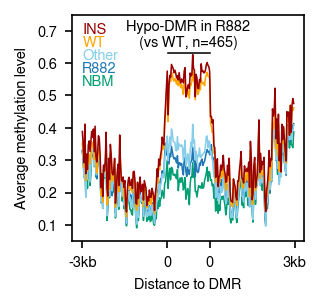

In [107]:
r882_dmrs = pd.read_csv('source_data/r882_vs_wt_dmrs.csv')
pileup_data = pd.read_csv('source_data/r882_wt_dmr_beta_landscape.csv')

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111)

for i, (c, status) in enumerate(zip(['#009e73', 'C0', 'skyblue', 'orange', '#990000'], ['NBM', 'R882', 'Other', 'WT', 'INS'])):
    
    v = pileup_data[pileup_data.status == status].beta.values
    
    ax.plot(v, lw=0.75, c=c)
    ax.text(0, 0.53 + 0.04 * i, status, color=c)

ax.plot([101, 150], [0.63, 0.63], c='k', lw=0.75, solid_capstyle='projecting')
ax.text(125, 0.65, 'Hypo-DMR in R882\n(vs WT, n=%d)' % (len(r882_dmrs[(r882_dmrs.q_value < 1e-2) & (r882_dmrs.mean_difference < 0)])), ha='center')

ax.set_xticks([0, 100, 150, 250])
ax.set_xticklabels(['-3kb', 0, 0, '3kb'])
ax.set_ylim([0.05, 0.75])

ax.set_ylabel('Average methylation level')
ax.set_xlabel('Distance to DMR')

save_figures('source_data_figures/dmr_analysis/r882_wt_dmr_beta_landscape')

### vs NBM DMRs

In [59]:
names = ['chrom', 'start', 'end', 'q_value', 'mean_difference' ,'num_CpGs', 'p_mwu', 'p_2d_ks', 'mean_g1', 'mean_g2']

ins_dmrs = pd.read_csv('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-ERRBS-DMR/result/INS_vs_NBM.metilene.dmr.tsv', sep='\t', names=names)
wt_dmrs = pd.read_csv('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-ERRBS-DMR/result/WT_vs_NBM.metilene.dmr.tsv', sep='\t', names=names)
other_dmrs = pd.read_csv('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-ERRBS-DMR/result/Other_vs_NBM.metilene.dmr.tsv', sep='\t', names=names)
r882_dmrs = pd.read_csv('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-ERRBS-DMR/result/R882_vs_NBM.metilene.dmr.tsv', sep='\t', names=names)

for dmrs in [ins_dmrs, wt_dmrs, other_dmrs, r882_dmrs]:
    dmrs['log_q_value'] = -np.log10(dmrs.q_value)

/data/project/dohoon/miniconda3/envs/dnmt3a/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [60]:
ins_dmrs.to_csv('source_data/ins_vs_nbm_dmrs.csv', index=False)
wt_dmrs.to_csv('source_data/wt_vs_nbm_dmrs.csv', index=False)
other_dmrs.to_csv('source_data/other_vs_nbm_dmrs.csv', index=False)
r882_dmrs.to_csv('source_data/r882_vs_nbm_dmrs.csv', index=False)

/data/project/dohoon/miniconda3/envs/dnmt3a/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


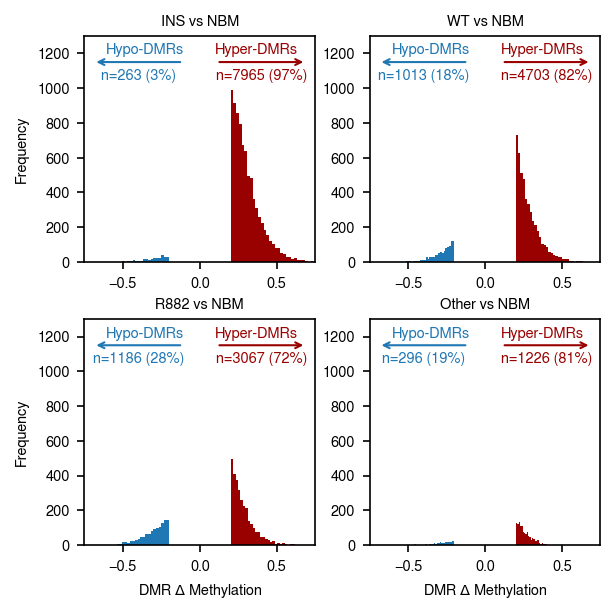

In [68]:
ins_dmrs = pd.read_csv('source_data/ins_vs_nbm_dmrs.csv')
wt_dmrs = pd.read_csv('source_data/wt_vs_nbm_dmrs.csv')
other_dmrs = pd.read_csv('source_data/other_vs_nbm_dmrs.csv')
r882_dmrs = pd.read_csv('source_data/r882_vs_nbm_dmrs.csv')

p_cutoff = 1e-2

y_max = 1300

fig = plt.figure(figsize=(2 * 2, 2 * 2))

for i, (dmrs, group) in enumerate(zip([ins_dmrs, wt_dmrs, r882_dmrs, other_dmrs], ['INS', 'WT', 'R882', 'Other'])):
    ax = fig.add_subplot(2, 2, i + 1)
    
    d_sig = dmrs[(dmrs.q_value < p_cutoff)]
    hypo_dmrs = dmrs[(dmrs.q_value < p_cutoff) & (dmrs.mean_difference < 0)]
    hyper_dmrs = dmrs[(dmrs.q_value < p_cutoff) & (dmrs.mean_difference > 0)]
    
    hypo_dmrs.mean_difference.plot.hist(bins=33, lw=0, fc='C0', histtype='stepfilled', ax=ax)
    hyper_dmrs.mean_difference.plot.hist(bins=33, lw=0, fc='#990000', histtype='stepfilled', ax=ax)
    
    ax.set_xlim([-0.75, 0.75])
    ax.set_ylim([0, y_max])
    
    ax.text(0.1, y_max - 80, f'Hyper-DMRs', ha='left', va='center', color='#990000', fontsize=7)
    ax.text(-0.1, y_max - 80, f'Hypo-DMRs', ha='right', va='center', color='C0', fontsize=7)
    
    ax.annotate('', (0.7, y_max - 150), (0.1, y_max - 150), arrowprops={'arrowstyle': '->', 'lw': 1, 'color': '#990000'})
    ax.annotate('', (-0.7, y_max - 150), (-0.1, y_max - 150), arrowprops={'arrowstyle': '->', 'lw': 1, 'color': 'C0'})
    
    ax.text(0.4, y_max - 250, f'n={len(hyper_dmrs)} ({len(hyper_dmrs) / len(d_sig):.0%})', ha='center', color='#990000', fontsize=7)
    ax.text(-0.4, y_max - 250, f'n={len(hypo_dmrs)} ({len(hypo_dmrs) / len(d_sig):.0%})', ha='center', color='C0', fontsize=7)
    
    ax.set_title(f'{group} vs NBM', fontsize=7, pad=5)
    ax.set_xlabel('DMR $\Delta$ Methylation', fontsize=7)
    if i not in [0, 2]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Frequency', fontsize=7)
        
    if i not in [2, 3]:
        ax.set_xlabel('')
    
plt.tight_layout(0.5)
save_figures('source_data_figures/dmr_analysis/vs_nbm_dmr_statistics')

### Beta pileup in INS-vs-NBM hyper-DMRs

In [75]:
intersect_results = glob.glob('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-DMR-PILEUP/result/intersect/*.ins_hyper.bed')
closest_results = glob.glob('/data2/project/SNUH_DNMT3A/pipelines/INSTABILITY-DBGAP-DMR-PILEUP/result/closest/*.ins_hyper.bed')

len(intersect_results), len(closest_results)

intersect_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'rel_pos']
closest_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'distance']

intersect_data = []

for fp in tqdm(intersect_results):
    sample = os.path.basename(fp).split('.')[0]
    
    tmp = pd.read_csv(fp, sep='\t', names=intersect_names)
    tmp['sample'] = sample
    
    intersect_data.append(tmp)
    
intersect_data = pd.concat(intersect_data)

intersect_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'rel_pos']
closest_names = ['cpg_chrom', 'cpg_start', 'cpg_end', 'beta', 'dmr_name', 'distance']

closest_data = []

for fp in tqdm(closest_results):
    sample = os.path.basename(fp).split('.')[0]
    
    tmp = pd.read_csv(fp, sep='\t', names=closest_names)
    tmp['sample'] = sample
    
    closest_data.append(tmp)
    
closest_data = pd.concat(closest_data)

intersect_data['distance_bin'] = pd.cut(intersect_data.rel_pos, bins=np.linspace(0, 1, 51))

intersect_data.head(3)

100%|██████████| 108/108 [00:39<00:00,  2.74it/s]


,cpg_chrom,cpg_start,cpg_end,beta,dmr_name,rel_pos,sample,distance_bin
0,chr1,910377,910379,0.684932,chr1:910376-910466,0.033333,SRR3088567,"(0.02, 0.04]"
1,chr1,910411,910413,0.711009,chr1:910376-910466,0.411111,SRR3088567,"(0.4, 0.42]"
2,chr1,910429,910431,0.714286,chr1:910376-910466,0.611111,SRR3088567,"(0.6, 0.62]"


In [77]:
intersect_data['status'] = intersect_data['sample'].map(run2status).fillna('NBM')
closest_data['status'] = closest_data['sample'].map(run2status).fillna('NBM')

closest_data_upstream = closest_data[closest_data.distance < 0].copy()
closest_data_downstream = closest_data[closest_data.distance > 0].copy()

closest_data_upstream['distance_bin'] = pd.cut(closest_data_upstream.distance, bins=np.linspace(-3000, 0, 101))
closest_data_downstream['distance_bin'] = pd.cut(closest_data_downstream.distance, bins=np.linspace(0, 3000, 101))

intersect_data_grouped = intersect_data.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()

%time closest_data_upstream_grouped = closest_data_upstream.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()
%time closest_data_downstream_grouped = closest_data_downstream.groupby(['status', 'distance_bin']).agg({'beta': 'mean'}).reset_index()

CPU times: user 2.92 s, sys: 146 ms, total: 3.07 s
Wall time: 3.07 s
CPU times: user 2.75 s, sys: 75.6 ms, total: 2.83 s
Wall time: 2.83 s


In [97]:
pileup_data = pd.concat([closest_data_upstream_grouped, intersect_data_grouped, closest_data_downstream_grouped])

In [98]:
pileup_data.to_csv('source_data/ins_nbm_dmr_beta_landscape.csv', index=False)

In [99]:
pileup_data = pd.read_csv('source_data/ins_nbm_dmr_beta_landscape.csv')

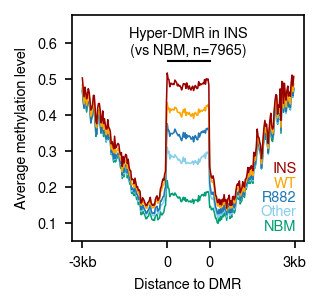

In [103]:
pileup_data = pd.read_csv('source_data/ins_nbm_dmr_beta_landscape.csv')

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111)

for i, (c, status) in enumerate(zip(['#009e73', 'skyblue', 'C0', 'orange', '#990000'], ['NBM', 'Other', 'R882', 'WT', 'INS'])):
    ax.plot(pileup_data[pileup_data.status == status].beta.values, lw=0.75, c=c)
    
    ax.text(252, 0.08 + 0.04 * i, status, ha='right', color=c)
    
ax.plot([101, 150], [0.55, 0.55], c='k', lw=1, solid_capstyle='projecting')
# ax.axvline(100, ls='--', lw=1, c='0.5', zorder=-1)
# ax.axvline(150, ls='--', lw=1, c='0.5', zorder=-1)

ax.text(125, 0.57, 'Hyper-DMR in INS\n(vs NBM, n=7965)', ha='center')

ax.set_xticks([0, 100, 150, 250])
ax.set_xticklabels(['-3kb', '0', '0', '3kb'])
ax.set_ylabel('Average methylation level')
ax.set_xlabel('Distance to DMR')

ax.set_ylim([0.05, 0.68])

save_figures('source_data_figures/dmr_analysis/ins_nbm_dmr_beta_landscape')